In [ ]:
"""
This program runs on server. Since spectra data are on server.

This program plot the spectrums in certain energy range in histogram

plot sum cts in certain energy range v.s. abundance
plot sum cts in certain energy range v.s. abundance relative err bar
"""

1 copy this to server

In [ ]:
# extract sum cts from the spectras
# Load the data and qpb spectra in dir
from glob import glob
from astropy.io import fits
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

# define paths
rootdir = '/data/yanling/XGAP-ABUN/data/alldata/XGAP'
savepath = f'{rootdir}/dats'
os.makedirs(savepath, exist_ok=True)
regname = 'R500-01'
dirs = glob(f'{rootdir}/SDSSTG*')
# initialize the dict
output_dict = {'ID':[]}
for inst in ['mos1S001', 'mos2S002', 'pnS003-0', 'pnS003-4']:
    for name in ['dat', 'bkg', 'net']:
        output_dict[f'{inst}-{name}'] = []
for dir in tqdm(dirs):
    srcname = dir.split('/')[-1]
    os.chdir(f'{dir}/{srcname}_{regname}/{srcname}_{regname}')
    output_dict['ID'].append(srcname)
    # for mos
    for inst in ['mos1S001', 'mos2S002', 'pnS003-0', 'pnS003-4']:
        if 'mos' in inst:
            erange = (0.5, 4)
            bkgext = 2
        elif 'pnS003-0' in inst:
            erange = (0.5, 1)
            bkgext = 1
        elif 'pnS003-4' in inst:
            erange = (1, 4)
            bkgext = 1
        else:
            raise ValueError('Wrong instrument!')
        bkgrmf = f"../../../{inst.split('S')[0]}-diag.rsp"
        datrmf = f'{inst}-{srcname}_{regname}.rmf'
        datpha = f'{inst}-obj-{srcname}_{regname}.pi'
        bkgpha = f'{inst}-allbkg-{srcname}_{regname}.pi'
        with fits.open(datrmf) as f1:
            dat_emsk = (f1[2].data['E_MIN']<erange[1]) & (f1[2].data['E_MIN']>erange[0])
        with fits.open(bkgrmf) as f2:
            bkg_emsk = (f2[bkgext].data['E_MIN']<erange[1]) & (f2[bkgext].data['E_MIN']>erange[0])
        with fits.open(datpha) as f3:
            dat = np.sum(f3[1].data['COUNTS'][dat_emsk])
            EXP = f3[1].header['EXPOSURE']
        with fits.open(bkgpha) as f4:
            bkg = np.sum(f4[1].data['RATE'][bkg_emsk]) * EXP
        output_dict[f'{inst}-dat'].append(np.round(dat, decimals = 1))
        output_dict[f'{inst}-bkg'].append(np.round(bkg, decimals = 1))
        output_dict[f'{inst}-net'].append(np.round(dat-bkg, decimals = 1))
        
df = pd.DataFrame(output_dict)
df.to_csv(f'{savepath}/sumcts_{regname}.csv')

2 plot the histograms

Text(0, 0.5, 'groups where cts in 0.1R500c equals to x axis')

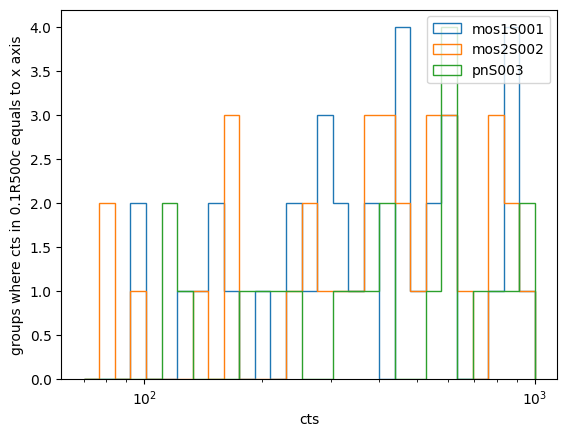

In [13]:
# read the csv
import matplotlib.pyplot as plt

my_rootdir = f'/Users/eusracenorth/Documents/work/XGAP-ABUN/alldata/XGAP'

df = pd.read_csv(f'{my_rootdir}/../dats/sumcts_R500-01.csv')
for inst in ['mos1S001', 'mos2S002', 'pnS003-0']:
    if 'mos' in inst:
        plt.hist(df[f'{inst}-dat'], histtype = 'step', label = inst, bins = np.logspace(np.log10(70), 3, 30))
    else: 
        plt.hist(df[f'pnS003-0-dat'] + df[f'pnS003-4-dat'], histtype = 'step', label = 'pnS003', bins = np.logspace(np.log10(70), 3, 30))
plt.legend()
plt.xscale('log')
plt.xlabel('cts')
plt.ylabel('groups where cts in 0.1R500c equals to x axis')

3 plot the cts in 0.1r500c vs abundance

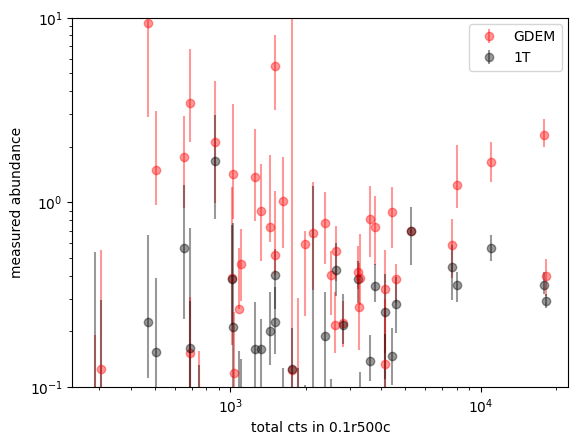

In [45]:
# sum the cts
sumcts = 0
for inst in ['mos1S001', 'mos2S002', 'pnS003-0', 'pnS003-4']:
    sumcts += df[f'{inst}-dat']

# GDEM in xspec
df_GD = pd.read_csv(f'{my_rootdir}/../dats/R500-01_GDEM_xspec.csv')
df_1T = pd.read_csv(f'{my_rootdir}/../dats/R500-01_1T_xspec.csv')
one = True
for id in df['ID']:
    
    if np.sum(df_GD['reg']==id) > 0:
        if one:
            plt.errorbar(sumcts[df['ID']==id], df_GD['Z-value'][df_GD['reg']==id], yerr = (df_GD['Z-errlo'][df_GD['reg']==id], df_GD['Z-errhi'][df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4, label = 'GDEM')
            plt.errorbar(sumcts[df['ID']==id], df_1T['Z-value'][df_1T['reg']==id], yerr = (df_1T['Z-errlo'][df_1T['reg']==id], df_1T['Z-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4, label = '1T')
            one = False
        else:
            plt.errorbar(sumcts[df['ID']==id], df_GD['Z-value'][df_GD['reg']==id], yerr = (df_GD['Z-errlo'][df_GD['reg']==id], df_GD['Z-errhi'][df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4)
            plt.errorbar(sumcts[df['ID']==id], df_1T['Z-value'][df_1T['reg']==id], yerr = (df_1T['Z-errlo'][df_1T['reg']==id], df_1T['Z-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4)

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 10)
plt.xlabel('total cts in 0.1r500c')
plt.ylabel('measured abundance')
plt.legend()

4 plot the cts in 0.1r500c vs temperature

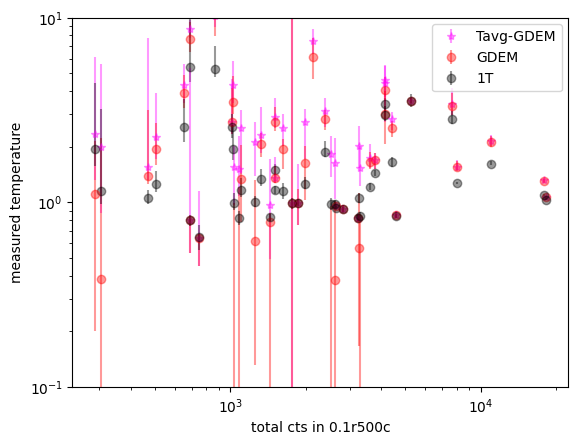

In [56]:
# sum the cts
sumcts = 0
for inst in ['mos1S001', 'mos2S002', 'pnS003-0', 'pnS003-4']:
    sumcts += df[f'{inst}-dat']

# GDEM in xspec
df_GD = pd.read_csv(f'{my_rootdir}/../dats/R500-01_GDEM_xspec.csv')
df_Tavg = pd.read_csv(f'{my_rootdir}/../dats/GDEM_Tavg_xspec.csv')

df_1T = pd.read_csv(f'{my_rootdir}/../dats/R500-01_1T_xspec.csv')
one = True
for id in df['ID']:
    if np.sum(df_GD['reg']==id) > 0:

        if one:
            
            plt.errorbar(sumcts[df['ID']==id], df_Tavg['Tavg'][df_Tavg['ID']==id], yerr = (abs(df_Tavg['Tavg']-df_Tavg['Tavg_lo'])[df_Tavg['ID']==id], abs(df_Tavg['Tavg_hi'] - df_Tavg['Tavg'])[df_Tavg['ID']==id]), fmt = '*', c = 'magenta', alpha = 0.4, label = 'Tavg-GDEM')
            plt.errorbar(sumcts[df['ID']==id], df_GD['T-value'][df_GD['reg']==id], yerr = (df_GD['T-errlo'][df_GD['reg']==id], df_GD['T-errhi'][df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4, label = 'GDEM')
            plt.errorbar(sumcts[df['ID']==id], df_1T['T-value'][df_1T['reg']==id], yerr = (df_1T['T-errlo'][df_1T['reg']==id], df_1T['T-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4, label = '1T')
            one = False
        else:
            plt.errorbar(sumcts[df['ID']==id], df_Tavg['Tavg'][df_Tavg['ID']==id], yerr = (abs(df_Tavg['Tavg']-df_Tavg['Tavg_lo'])[df_Tavg['ID']==id], abs(df_Tavg['Tavg_hi'] - df_Tavg['Tavg'])[df_Tavg['ID']==id]), fmt = '*', c = 'magenta', alpha = 0.4)

            plt.errorbar(sumcts[df['ID']==id], df_GD['T-value'][df_GD['reg']==id], yerr = (df_GD['T-errlo'][df_GD['reg']==id], df_GD['T-errhi'][df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4)
            plt.errorbar(sumcts[df['ID']==id], df_1T['T-value'][df_1T['reg']==id], yerr = (df_1T['T-errlo'][df_1T['reg']==id], df_1T['T-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4)

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 10)
plt.xlabel('total cts in 0.1r500c')
plt.ylabel('measured temperature')
plt.legend()

5 plot the cts in 0.1r500c vs norm

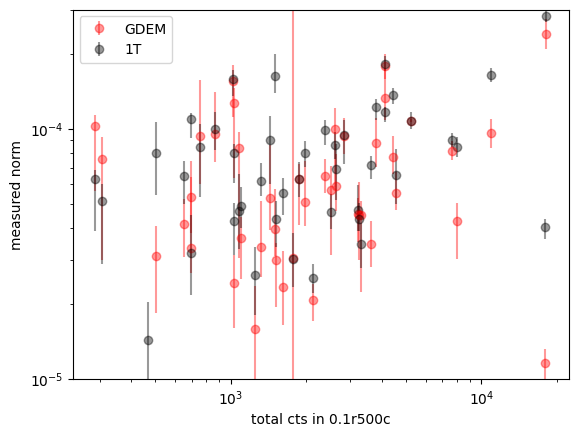

In [63]:
# sum the cts
sumcts = 0
for inst in ['mos1S001', 'mos2S002', 'pnS003-0', 'pnS003-4']:
    sumcts += df[f'{inst}-dat']

# GDEM in xspec
df_GD = pd.read_csv(f'{my_rootdir}/../dats/R500-01_GDEM_xspec.csv')
df_1T = pd.read_csv(f'{my_rootdir}/../dats/R500-01_1T_xspec.csv')
one = True
for id in df['ID']:
    
    if np.sum(df_GD['reg']==id) > 0:
        if one:
            plt.errorbar(sumcts[df['ID']==id], df_GD['n-value'][df_GD['reg']==id], yerr = (df_GD['n-errlo'][df_GD['reg']==id], df_GD['n-errhi'][df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4, label = 'GDEM')
            plt.errorbar(sumcts[df['ID']==id], df_1T['n-value'][df_1T['reg']==id], yerr = (df_1T['n-errlo'][df_1T['reg']==id], df_1T['n-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4, label = '1T')
            one = False
        else:
            plt.errorbar(sumcts[df['ID']==id], df_GD['n-value'][df_GD['reg']==id], yerr = (abs(df_GD['n-errlo'])[df_GD['reg']==id], abs(df_GD['n-errhi'])[df_GD['reg']==id]), fmt = 'o', c = 'r', alpha = 0.4)
            plt.errorbar(sumcts[df['ID']==id], df_1T['n-value'][df_1T['reg']==id], yerr = (df_1T['n-errlo'][df_1T['reg']==id], df_1T['n-errhi'][df_1T['reg']==id]), fmt = 'o', c = 'k', alpha = 0.4)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 3e-4)
plt.xlabel('total cts in 0.1r500c')
plt.ylabel('measured norm')
plt.legend()

In [54]:
            
df_Tavg['ID'][(df_Tavg['Tavg']-df_Tavg['Tavg_lo'] )<0]


28    SDSSTG16386
Name: ID, dtype: object